<a href="https://colab.research.google.com/github/shekhart47/Deep-Learning-for-Computer-Vision-with-Python/blob/main/CS329S_Problem_Set_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS329S Problem Set 2

# Overview

In the last assignment, we’ve tested some public ML systems. In this assignment, we’ll familiarize ourselves with how to train and evaluate models. In this assignment, you'll familiarize yourself with the open source HuggingFace API by evaluating fine-tuned models on a variety of criteria. 

# Submission
1. Click ***File > Save a Copy in Drive*** to save your own copy of the document to work in and submit.
2. Please answer all the problems from this problem set in your Colab notebook.
3. Submit **both** `CS329S Problem Set 2.ipynb` notebook file and `CS329S Problem Set 2.pdf` to Gradescope. 
  - To download the `CS329S Problem Set 2.ipynb`: File > Download .ipynb
  - To download the `CS329S Problem Set 2.pdf`: File > Print

Please make sure that your answers are not in collapsed cells for your PDF!

**This assignment is meaty. Start early!**


**Tip**: You can use the colab GPU for this by selecting:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**


# Part I. Understanding pretrained models

Some of the HuggingFace modules that you might find useful for this assignment.
- [`load_dataset`](https://huggingface.co/docs/datasets/loading_datasets.html)
- [`pipelines`](https://huggingface.co/transformers/main_classes/pipelines.html)
- [`Trainer`](https://huggingface.co/transformers/main_classes/trainer.html)

Run the following cells to set up the necessary prerequisites. Feel free to modify the cells to import any module you need.

In [1]:
!pip install -q transformers
!pip install -q datasets

     |████████████████████████████████| 3.5 MB 4.0 MB/s 
     |████████████████████████████████| 6.8 MB 56.0 MB/s 
     |████████████████████████████████| 895 kB 76.2 MB/s 
     |████████████████████████████████| 67 kB 6.8 MB/s 
     |████████████████████████████████| 596 kB 78.4 MB/s 
     |████████████████████████████████| 311 kB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 47.6 MB/s 
     |████████████████████████████████| 133 kB 54.1 MB/s 
     |████████████████████████████████| 243 kB 58.2 MB/s 
     |████████████████████████████████| 271 kB 56.5 MB/s 
     |████████████████████████████████| 144 kB 94.5 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 


In [2]:
import numpy as np
import random

from datasets import load_dataset
from datasets import load_metric
from transformers import pipeline
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

## Problem 1: Setup

We’ll examine pretrained language models’ performance for the task of sentiment analysis with two classes. For Problem 1 and Problem 2 of this assignment, you’ll need to pick the following:

- **Fine-tuned model**: choose one pretrained language model that has been fine-tuned on the IMDB dataset from the [HuggingFace Model Hub](https://huggingface.co/models). You can see the list of available models trained on IMDB [here](https://huggingface.co/models?search=imdb). Examples:
    - `roberta-base-imdb` is `robert-base` that has been fine-tuned on the IMDB dataset.
    - `distilbert-base-uncased-imdb` is `distilbert-base-uncased` that has been fine-tuned on the IMDB dataset.

- **Out-of-distribution dataset**: pick a **binary label** sentiment analysis dataset that IS NOT IMDB from HuggingFace Datasets interface (some of them have more than two labels, so make sure you pick one with binary labels!). You can find the list of sentiment analysis tasks [here](https://huggingface.co/datasets?filter=task_ids:sentiment-classification).


### 1.1 Understanding your fine-tuned model [5 points]



#### a. (1 point) What fine-tuned model did you choose? What’s its pretrained LM counterpart?


**Answer**:

I used distilbert-base-uncased as the tuned-model for this task. This model is based on pretrained Google's BERT model.

#### b. (1 point) Is your model cased or uncased? Why did you choose that?

**Answer**:

The distilbert-base-uncased model is uncased. This model is trained by distilling based BERT and thus has 60% less parameters than the parent model and is thus faster for inference while maintaining 95% of BERT's performance.

References:

https://huggingface.co/distilbert-base-uncased


https://huggingface.co/docs/transformers/model_doc/distilbert

#### c. (3 points) What is the number of parameters in your model? You can find this number either from the original paper or write code to count its number of parameters.

In [3]:
################## (OPTIONAL) YOUR CODE HERE ##################
# Find the number of parameters in your model
###############################################################
from transformers import DistilBertModel, DistilBertConfig

# Initializing a DistilBERT configuration
configuration = DistilBertConfig()

# Initializing a model from the configuration
model = DistilBertModel(configuration)

# Accessing the model configuration
configuration = model.config

print(configuration)


DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "transformers_version": "4.16.2",
  "vocab_size": 30522
}



**Answer**:

The DistilBERT has 66 million parameters which are significantly less that the BERT-base model which has 110 million paramters

Reference : 

Table 3 - https://arxiv.org/pdf/1910.01108.pdf

### 1.2 Understanding the [IMDB dataset](https://ai.stanford.edu/~amaas/data/sentiment/) [3 points]

**Tip**: The IMDB dataset can also be explored in the Hugging Face model hub ([IMDb](https://huggingface.co/datasets/imdb)) 

**Example: Loading Dataset**

The following cell shows how to use the HuggingFace [`Datasets`](https://github.com/huggingface/datasets) library to download and prepare the IMDb dataset. 


In [4]:
dataset = load_dataset("imdb")

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset
dataset['test'][0]

{'label': 0,
 'text': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'

**Alternatively**, you can also read in datasets from raw text. Checkout this [tutorial](https://huggingface.co/transformers/custom_datasets.html?highlight=imdb%20rating%20dataset) for more details.

In [5]:
! wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
! tar -xf aclImdb_v1.tar.gz

--2022-02-18 23:45:51--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  19.3MB/s    in 7.2s    

2022-02-18 23:45:59 (11.2 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [6]:
from pathlib import Path

def read_imdb_split(split_dir):
    split_dir = Path(split_dir)
    texts = []
    labels = []
    for label_dir in ["pos", "neg"]:
        for text_file in (split_dir/label_dir).iterdir():
            texts.append(text_file.read_text())
            labels.append(0 if label_dir is "neg" else 1)

    return texts, labels

train_texts, train_labels = read_imdb_split('aclImdb/train')
test_texts, test_labels = read_imdb_split('aclImdb/test')

In [7]:
################## (OPTIONAL) YOUR CODE HERE ##################
# Feel free to write your own code to import the IMDB dataset.
###############################################################
len(test_labels)

25000

In [8]:
train_texts[0]

'"Telefilms" tend to fall under the pitfalls of a low budget and a hasty shooting schedule, which is why this film always tends to buck the trend.<br /><br />George C. Scott embodies Ebenezer Scrooge perfectly, fully encompassing all of his cold tendencies, and still makes him a simpathetic character. The production value for this film was exceptional, never relying on boffo special effects or soundstage set-ups, yet relying on the depth and clarity of on-site shooting and strong backdrops. A movie that certainly stands alone.'

#### a. (1 point) Plot the reviews' lengths (word count) as a histogram for the train set, the test set, and the entire dataset.

- If you need some help generating plots, checkout matplotlib [tutorial](https://matplotlib.org/3.1.1/gallery/statistics/hist.html)


**Answer**:

In [9]:
################## YOUR CODE HERE ##################
# Plot the review's lengths
####################################################


def get_reviews_length(data):
  text_length = [len(item) for item in data]
  return text_length

In [10]:
text_length_train = get_reviews_length(train_texts)
text_length_test = get_reviews_length(test_texts)
all_reviews = train_texts + test_texts
all_review_length = get_reviews_length(all_reviews)

(array([1.7426e+04, 5.3820e+03, 1.4910e+03, 5.3500e+02, 1.4800e+02,
        1.1000e+01, 4.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   52. ,  1417.2,  2782.4,  4147.6,  5512.8,  6878. ,  8243.2,
         9608.4, 10973.6, 12338.8, 13704. ]),
 <a list of 10 Patch objects>)

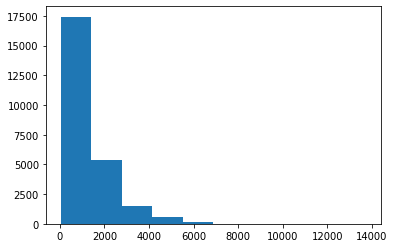

In [11]:
plt.hist(text_length_train)

(array([1.7044e+04, 5.6340e+03, 1.5500e+03, 5.4400e+02, 2.2100e+02,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([   32. ,  1327.6,  2623.2,  3918.8,  5214.4,  6510. ,  7805.6,
         9101.2, 10396.8, 11692.4, 12988. ]),
 <a list of 10 Patch objects>)

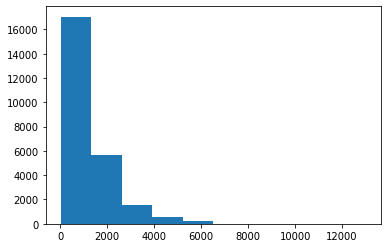

In [12]:
plt.hist(text_length_test)

(array([3.4883e+04, 1.0845e+04, 2.9210e+03, 1.0330e+03, 2.9300e+02,
        1.4000e+01, 4.0000e+00, 3.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([   32. ,  1399.2,  2766.4,  4133.6,  5500.8,  6868. ,  8235.2,
         9602.4, 10969.6, 12336.8, 13704. ]),
 <a list of 10 Patch objects>)

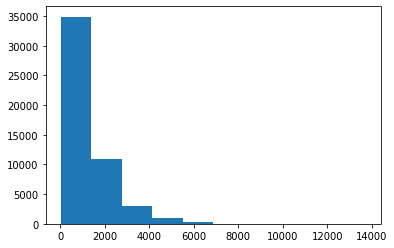

In [13]:
plt.hist(all_review_length)

#### b. (1 point) Report the label distribution (number of positive and negative examples) for both the train and test splits.

In [14]:
################## YOUR CODE HERE ##################
# Find the label distributions
####################################################

**Answer**:

In [17]:
from collections import Counter

In [18]:
counter_train = Counter()
counter_train.update(train_labels)
print("Label Distribution - Train : ", counter_train)
counter_test = Counter()
counter_test.update(test_labels)
print("Label Distribution - Test : ", counter_test)

Label Distribution - Train :  Counter({1: 12500, 0: 12500})
Label Distribution - Test :  Counter({1: 12500, 0: 12500})


#### c. (1 point) What evaluation metric(s) would be appropriate for this dataset? Why?

**Answer**:

After looking at the label distribution in the dataset, since this is a binary (sequence) classification model, we will use the following classification metrics to evaluate the model's predictions against the ground truth:

1) Precision

2) Recall

3) Fscore

### 1.3 Understanding the out-of-distribution dataset [3 points]

#### a. (1 point) What's the name of your out-of-distribution dataset? Include a link. 

**Answer**:

Amazon Reviews Dataset : https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz

NOTE : 
The dataset is also loaded in huggigface list of datasets, so I'll be using huggingface version of this dataset, which in turn will fecth it from the above s3 bucket.  After loading the data, I will be using keras framework to build and test my model

#### b. (1 point) Describe your dataset, including its splits, its columns, and their statistics. 

In [ ]:
################## YOUR CODE HERE ##################
# Load your data and find your dataset's statistics
####################################################

**Answer**:




Code for the loading the dataset : 

NOTE : The below commands will load all the dataset from the s3 bucket with the predefined train split. We will use this dataset, to create our own train and test splits

In [19]:
from datasets import list_datasets
from datasets import load_dataset
import pandas as pd
datasets_list = list_datasets()
len(datasets_list)
print(', '.join(dataset for dataset in datasets_list))

acronym_identification, ade_corpus_v2, adversarial_qa, aeslc, afrikaans_ner_corpus, ag_news, ai2_arc, air_dialogue, ajgt_twitter_ar, allegro_reviews, allocine, alt, amazon_polarity, amazon_reviews_multi, amazon_us_reviews, ambig_qa, americas_nli, ami, amttl, anli, app_reviews, aqua_rat, aquamuse, ar_cov19, ar_res_reviews, ar_sarcasm, arabic_billion_words, arabic_pos_dialect, arabic_speech_corpus, arcd, arsentd_lev, art, arxiv_dataset, ascent_kb, aslg_pc12, asnq, asset, assin, assin2, atomic, autshumato, babi_qa, banking77, bbaw_egyptian, bbc_hindi_nli, bc2gm_corpus, beans, best2009, bianet, bible_para, big_patent, billsum, bing_coronavirus_query_set, biomrc, biosses, blbooks, blbooksgenre, blended_skill_talk, blimp, blog_authorship_corpus, bn_hate_speech, bnl_newspapers, bookcorpus, bookcorpusopen, boolq, bprec, break_data, brwac, bsd_ja_en, bswac, c3, c4, cail2018, caner, capes, casino, catalonia_independence, cats_vs_dogs, cawac, cbt, cc100, cc_news, ccaligned_multilingual, cdsc, cdt

In [29]:

dataset = load_dataset('amazon_us_reviews', 'Mobile_Electronics_v1_00')

Reusing dataset amazon_us_reviews (/root/.cache/huggingface/datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563)


  0%|          | 0/1 [00:00<?, ?it/s]

We make a new columns called Sentiment by transforming the star_rating column, by assigning all rating with score ?=3 as 1 and 0 otherwise,, . Next, we extract review_body and Sentiment from the dataset and this gives us our complete dataset for buidling our model.

amazon_us_reviews

In [30]:
def process_dataset(dataset):
  dataset = pd.DataFrame(dataset['train'][:])
  dataset["Sentiment"] = dataset["star_rating"].apply(lambda score: "positive" if score >= 3 else "negative")
  dataset['Sentiment'] = dataset['Sentiment'].map({'positive':1, 'negative':0})
  dataset = dataset[['review_body','Sentiment']]
  dataset.columns = ['Reviews','Sentiment']

  return dataset

In [31]:
dataset = process_dataset(dataset)

In [32]:
dataset.head()

,Reviews,Sentiment
0,"As advertised. Everything works perfectly, I'm...",1
1,it's great,1
2,These work great and fit my life proof case fo...,1
3,Work very well but couldn't get used to not he...,1
4,"Be careful with these products, I have bought ...",0


### Summary Statistics - All data

### Engineer Review Length Feature to understand length of review

In [33]:
dataset['Review_Length'] = dataset['Reviews'].apply(lambda x : len(x))

Histogram of Review Length for entire dataset


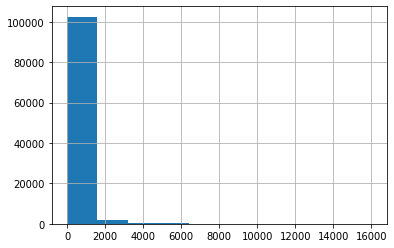

In [34]:
print("Histogram of Review Length for entire dataset")
dataset['Review_Length'].hist()

**Label ditribution in the dataset**

In [35]:
dataset['Sentiment'].value_counts()

1    80077
0    24898
Name: Sentiment, dtype: int64

Word Count in Raw (unprocessed) Dataset

In [36]:
counter = Counter()
result = [counter.update(item.split()) for item in dataset['Reviews']]
result = pd.DataFrame.from_dict(counter, orient='index').reset_index()
result = result.rename(columns={'index':'Token', 0:'count'})

In [37]:
print("Summary Statistics for features : Review Length and Sentiment")
dataset[['Review_Length','Sentiment']].describe()

Summary Statistics for features : Review Length and Sentiment


,Review_Length,Sentiment
count,104975.000000,104975.000000
mean,342.306425,0.762820
std,526.121531,0.425356
min,0.000000,0.000000
25%,115.000000,1.000000
50%,190.000000,1.000000
75%,381.000000,1.000000
max,16009.000000,1.000000


Top 100 words occuring in the raw(unprocessed) dataset

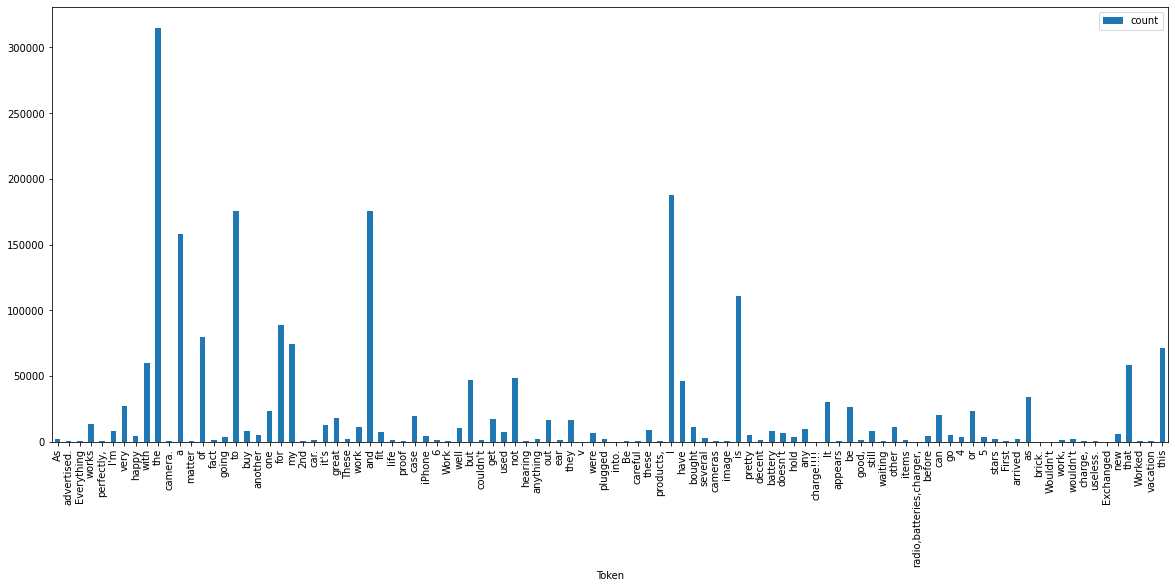

In [38]:
result.head(100).plot.bar(x = 'Token', y = 'count', figsize = (20,8))

Train Test Split of the Dataset

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(dataset['Reviews'], dataset['Sentiment'], test_size=0.33, random_state=412)
X_train = pd.DataFrame(X_train, columns = ['Reviews'])
X_test = pd.DataFrame(X_test, columns = ['Reviews'])

Word Count in Raw (unprocessed) Train Dataset

In [41]:
counter = Counter()
result = [counter.update(item.split()) for item in X_train['Reviews']]
result_train = pd.DataFrame.from_dict(counter, orient='index').reset_index()
result_train = result_train.rename(columns={'index':'Token', 0:'count'})

Top 100 words occuring in the raw(unprocessed) train dataset

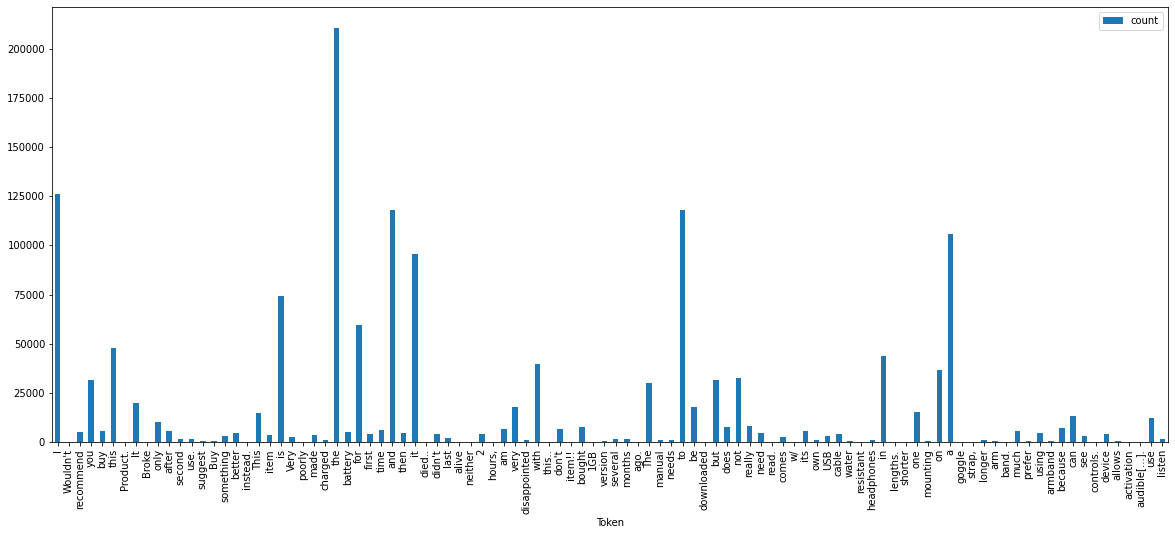

In [42]:
result_train.head(100).plot.bar(x = 'Token', y = 'count', figsize = (20,8))

Word Count in Raw (unprocessed) Test Dataset

In [43]:
counter = Counter()
result = [counter.update(item.split()) for item in X_test['Reviews']]
result_test = pd.DataFrame.from_dict(counter, orient='index').reset_index()
result_test = result_test.rename(columns={'index':'Token', 0:'count'})

Top 100 words occuring in the raw(unprocessed) test dataset

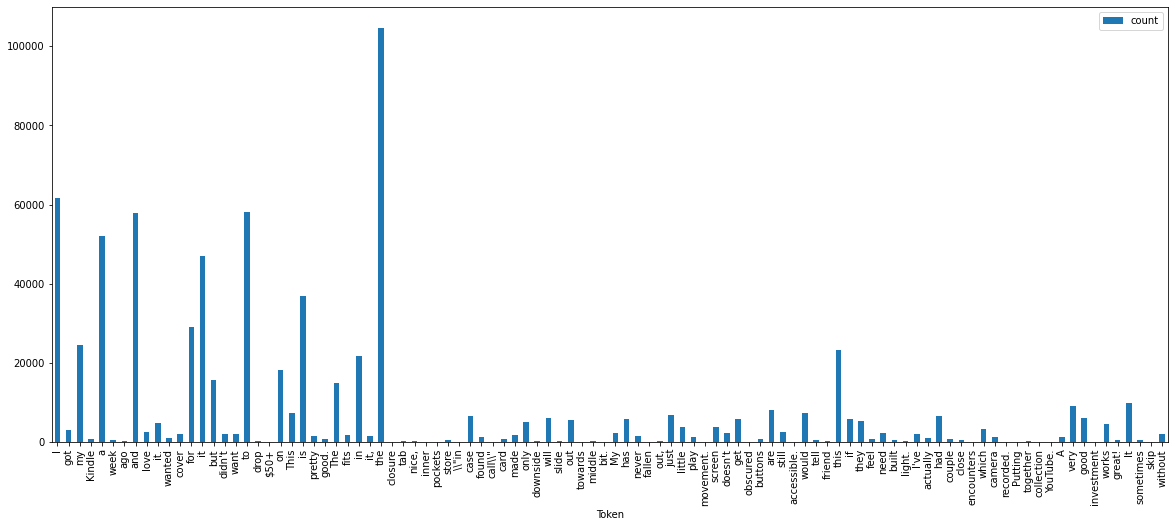

In [44]:
result_test.head(100).plot.bar(x = 'Token', y = 'count', figsize = (20,8))

#### c. (1 point) Report the label distribution (number of positive and negative examples) for both the train and test splits.

In [45]:
################## YOUR CODE HERE ##################
# Plot the label distribution
####################################################

In [46]:
print("Label Distribution  - Train Dataset")
Counter(y_train)

Label Distribution  - Train Dataset


Counter({0: 16762, 1: 53571})

In [47]:
print("Label Distribution  - Test Dataset")
Counter(y_test)

Label Distribution  - Test Dataset


Counter({0: 8136, 1: 26506})

## Problem 2. Training from scratch v.s. pretrained-model

### 2.1 Train a sentiment analysis model from scratch [10 points with 5 extra credit]

Use any framework (e.g. sklearn, PyTorch, Keras, TensorFlow) and any architecture (e.g. Logistic Regression, LSTM, Transformers), train a sentiment analysis model from scratch to get an accuracy of at least 85% on the test split of the IMDB dataset.

- **5 extra points if your model’s accuracy is above 90%**

In [48]:
################## YOUR CODE HERE ##################

train_texts, train_labels = read_imdb_split('aclImdb/train')
test_texts, test_labels = read_imdb_split('aclImdb/test')
####################################################

In [49]:
type(train_texts)

list

In [50]:
import string
import re
from os import listdir
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from pickle import dump

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [53]:
from pickle import load
from numpy import array
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from sklearn.metrics import confusion_matrix,classification_report, precision_recall_curve
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import pipeline
import torch
import matplotlib.pyplot as plt

In [54]:
def clean_doc(doc):
  # split into tokens by white space
  tokens = doc.split()
  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]
  # filter out short tokens
  tokens = [word for word in tokens if len(word) > 1]

  tokens = [word.lower() for word in tokens]
  tokens = ' '.join(tokens)
  return tokens

In [55]:
def process_docs(review):
  
  tokens = clean_doc(review)
  return tokens

In [56]:
def get_cleaned_reviews(X_train, X_test):
  train_documents = []
  result = [train_documents.append(process_docs(item)) for item in X_train]

  test_documents = []
  result = [test_documents.append(process_docs(item)) for item in X_test]

  return train_documents, test_documents

In [57]:
train_documents, test_documents = get_cleaned_reviews(train_texts, test_texts)

In [58]:
def save_dataset(dataset, filename):
  dump(dataset, open(filename, 'wb'))
  print('Saved: %s' % filename)

In [59]:
save_dataset([train_documents, train_labels], 'train.pkl')
save_dataset([test_documents, test_labels], 'test.pkl')

Saved: train.pkl
Saved: test.pkl


In [60]:
# load a clean dataset
def load_dataset(filename):
  return load(open(filename, 'rb'))
# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer
# calculate the maximum document length
def max_length(lines):
  return max([len(s.split()) for s in lines])
# encode a list of lines
def encode_text(tokenizer, lines, length):
# integer encode
  encoded = tokenizer.texts_to_sequences(lines)
  # pad encoded sequences
  padded = pad_sequences(encoded, maxlen=length, padding='post')
  return padded

In [61]:
# define the model
def define_model(length, vocab_size):
  # channel 1
  inputs1 = Input(shape=(length,))
  embedding1 = Embedding(vocab_size, 100)(inputs1)
  conv1 = Conv1D(32, 4, activation='relu')(embedding1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = MaxPooling1D()(drop1)
  flat1 = Flatten()(pool1)
  # channel 2
  inputs2 = Input(shape=(length,))
  embedding2 = Embedding(vocab_size, 100)(inputs2)
  conv2 = Conv1D(32, 6, activation='relu')(embedding2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = MaxPooling1D()(drop2)
  flat2 = Flatten()(pool2)
  # channel 3
  inputs3 = Input(shape=(length,))
  embedding3 = Embedding(vocab_size, 100)(inputs3)
  conv3 = Conv1D(32, 8, activation='relu')(embedding3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = MaxPooling1D()(drop3)
  flat3 = Flatten()(pool3)
  # merge
  merged = concatenate([flat1, flat2, flat3])
  # interpretation
  dense1 = Dense(10, activation='relu')(merged)
  outputs = Dense(1, activation='sigmoid')(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  # compile
  
  model.compile(loss='binary_crossentropy', optimizer= 'adam',  metrics=['accuracy'])
  # summarize
  model.summary()
  plot_model(model, show_shapes=True, to_file='model.png')
  return model

In [62]:
def load_datasets():

  trainLines, trainLabels = load_dataset('train.pkl')
  testLines, testLabels = load_dataset('test.pkl')
  # create tokenizer
  tokenizer = create_tokenizer(trainLines)
  # calculate max document length
  length = max_length(trainLines)
  print('Max document length: %d' % length)
  # calculate vocabulary size
  vocab_size = len(tokenizer.word_index) + 1
  print('Vocabulary size: %d' % vocab_size)
  # encode data
  trainX = encode_text(tokenizer, trainLines, length)
  testX = encode_text(tokenizer, testLines, length)

  return trainX,testX,trainLabels,testLabels, length, vocab_size

In [63]:
# load datasets
trainX,testX,trainLabels,testLabels, length, vocab_size= load_datasets()
# define model
model = define_model(length, vocab_size)

Max document length: 1480
Vocabulary size: 117362
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1480)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1480)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1480)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1480, 100)    11736200    ['input_1[0][0]']                
                                            

Below Cell Trains a model on the IMDB dataset

In [ ]:
# results = pd.DataFrame()
# accuracy = []
# batches = []
# epochs = []
# for b_size in [16,32,64]:
#     for epoch in [10,50,100]:
#       print("Batch Size : ", b_size, "Epochs : ", epoch)
#       print("\n")

#       model.fit([trainX,trainX,trainX], array(trainLabels),batch_size = b_size, epochs = epoch)
#       _,acc = model.evaluate([testX, testX, testX], array(testLabels))
#       accuracy.append(acc)
#       batches.append(b_size)
#       epochs.append(epoch)
#       print("Test Set Accuracy : ", acc)
      
#       model.save('model-'+str(b_size) + '-' + str(epoch) + '.h5')
# results['Batch'] = batches
# results['Epochs'] = epochs
# results['Test-Accuracy'] = accuracy



### 2.2 Evaluate your model and the fine-tuned model on IMDB [11 points]

**Tip**: You might find [`TextClassificationPipeline`](https://huggingface.co/transformers/main_classes/pipelines.html#transformers.TextClassificationPipeline) helpful. 

#### a. (1 point) Randomly sample 1000 examples from the test split.

In [ ]:
################## YOUR CODE HERE ##################

####################################################

**Random Sampling of 1000 data points from Test Set**

In [64]:
testX = pd.DataFrame(testX)
testLabels = pd.DataFrame(testLabels)
test_Data = pd.concat([testX, testLabels], axis = 1)


print( "1000 samples in terms of  Percetange : ", 1000 / testX.shape[0])
sample_percentage = 1000 / test_Data.shape[0]
sample_testData = test_Data.sample(frac= sample_percentage, replace=True, random_state=412)
sample_testX = sample_testData.iloc[:,:-1]
sample_test_Labels = sample_testData.iloc[:,-1]
sample_testX = sample_testX.values
sample_test_Labels = sample_test_Labels.values

1000 samples in terms of  Percetange :  0.04


#### b. (2 points) Use **your model** to make predictions on these examples and output predicted labels and associated probabilities.

In [ ]:
################## YOUR CODE HERE ##################

####################################################
from tensorflow.keras.models import load_model
model = load_model('/content/model-16-10.h5')

**Identifying Thrshold for Converting Probabilities to labels**

**Evaluating Predictions on Training Data, to select threshold which results in maximum accuracy. We will use the same threshold to convert predictions (probabilities) on test data to labels**

In [ ]:


def compute_performance(predictions, y_ground_truth):
    result = []
    for i in range(1,1000,1):
        threshold = i/1000
        y_pred_int  = [1 if item >= threshold else 0 for item in predictions]
        
        #vector = compute_net_profit(y_pred_int,y_test,profits_Xtest)
        
        #TP_Net = vector[0]
        #FP_Net = vector[1]
        #FN_Net = vector[2]
        #TN_Net = vector[3]    

        a = confusion_matrix(y_ground_truth,y_pred_int)
#        loss = log_loss(y_test,y_pred_int)
        tp = a[0,0]
        fp = a[0,1]
        fn = a[1,0]
        tn = a[1,1]
        
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        accuracy = (tp+tn)/(tp+tn+fp+fn)
        
        F1 = 2 * (precision * recall) / (precision + recall)
        
        
        result.append((threshold, precision, recall,accuracy,F1))
    result_df = pd.DataFrame(result, columns = ['Threshold','Precision','Recall','Accuracy','F1']).sort_values(by = 'F1',ascending = False)
    return result_df

In [ ]:
predictions_train = list(model.predict([trainX,trainX,trainX], batch_size = 16))
model_result = compute_performance(predictions_train, list(trainLabels))

In [ ]:
model_result

,Threshold,Precision,Recall,Accuracy,F1
732,0.733,1.00000,0.999680,0.99984,0.999840
739,0.740,1.00000,0.999680,0.99984,0.999840
731,0.732,1.00000,0.999680,0.99984,0.999840
733,0.734,1.00000,0.999680,0.99984,0.999840
734,0.735,1.00000,0.999680,0.99984,0.999840
...,...,...,...,...,...
997,0.998,1.00000,0.993167,0.99656,0.996572
2,0.003,0.99232,1.000000,0.99616,0.996145
1,0.002,0.99120,1.000000,0.99560,0.995581
0,0.001,0.98872,1.000000,0.99436,0.994328


In [ ]:
selected_threshold = model_result[model_result['Accuracy'] == max(model_result['Accuracy'])]['Threshold'].values[0]
print("Selected Threshold on Training Set : " , selected_threshold)

Selected Threshold on Training Set :  0.733


**Generating Predictions on Sample of Test Set**

In [ ]:
predictions_sample = model.predict([sample_testX,sample_testX,sample_testX], batch_size = 16)

In [ ]:
_, acc = model.evaluate([sample_testX,sample_testX,sample_testX], array(sample_test_Labels), verbose=0)
print('Sample Test Accuracy: %.2f' % (acc*100))

Sample Test Accuracy: 86.10


**Converting Sample Test Set Prediction Probabilities to Labels using selected threshold**

In [ ]:
predictions_sample = model.predict([sample_testX,sample_testX,sample_testX], batch_size = 16)
predictions_sample = list(predictions_sample)
predictions_sample = pd.DataFrame(predictions_sample, columns = ['Probabilities'])
selected_threshold = 0.733
predictions_sample['Labels'] = predictions_sample['Probabilities'].apply(lambda x :  1 if x >= selected_threshold else  0)

In [ ]:
print("Sample Test Probabilities and Labels")

predictions_sample

Sample Test Probabilities and Labels


,Probabilities,Labels
0,2.154480e-19,0
1,9.998713e-01,1
2,9.999994e-01,1
3,1.610951e-07,0
4,7.397356e-09,0
...,...,...
995,9.999995e-01,1
996,8.580864e-01,1
997,1.000000e+00,1
998,3.211959e-03,0


#### c. (2 points) Evaluate and report **your model’s** performance on these 1000 examples using the metric specified in 1.2 (c).

In [ ]:
################## YOUR CODE HERE ##################

####################################################

In [ ]:
def get_model_performance(sample_test_Labels, predictions_sample):
    

  a = confusion_matrix(sample_test_Labels,predictions_sample)

  tp = a[0,0]
  fp = a[0,1]
  fn = a[1,0]
  tn = a[1,1]

  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  accuracy = (tp+tn)/(tp+tn+fp+fn)

  F1 = 2 * (precision * recall) / (precision + recall)
  print("Model's performance on " , len(sample_test_Labels) ,  " samples of Test Set :  ")
  print("Accuracy : ", accuracy)
  print("Precision : ", precision)
  print("Recall : ", recall)
  print("F1 : ", F1)

In [ ]:
get_model_performance(list(sample_test_Labels), list(predictions_sample['Labels']))

Model's performance on 1000 samples of Test Set :  
Accuracy :  0.852
Precision :  0.8793456032719836
Recall :  0.8285163776493256
F1 :  0.8531746031746031


#### d. (2 points) Use the **fine-tuned model** to make predictions on these examples and output predicted labels and associated probabilities.


In [ ]:
################## YOUR CODE HERE ##################
# nlp = pipeline(...)
####################################################

In [65]:
# loading train and test dataset



# trainLines, trainLabels = load_dataset('train.pkl')
# testLines, testLabels = load_dataset('test.pkl')


# test_texts, test_labels

trainLines = pd.DataFrame(train_texts)
testLines = pd.DataFrame(test_texts)

trainLabels = pd.DataFrame(train_labels)
testLabels = pd.DataFrame(test_labels)

train = pd.concat([trainLines,trainLabels], axis = 1)
test = pd.concat([testLines,testLabels], axis = 1)
train.columns = ['reviews','labels']
test.columns = ['reviews','labels']



# creating sample dataset from test dataset
print( "1000 samples in terms of  Percetange : ", 1000 / testLines.shape[0])
sample_percentage = 1000 / test.shape[0]
sample_testData = test.sample(frac= sample_percentage, replace=True, random_state=412)
train, val = train_test_split(train, test_size=0.2, random_state=42, shuffle=True)



# building model and tokenizer object
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(set(train['labels']))).to('cuda')
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer.max_model_input_sizes

1000 samples in terms of  Percetange :  0.04


Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

{'distilbert-base-cased': 512,
 'distilbert-base-cased-distilled-squad': 512,
 'distilbert-base-german-cased': 512,
 'distilbert-base-multilingual-cased': 512,
 'distilbert-base-uncased': 512,
 'distilbert-base-uncased-distilled-squad': 512}

In [66]:
# encoding train, validation , test and sample_test datasets

train_encodings = tokenizer(train['reviews'].to_list(), truncation=True, padding = "max_length")
val_encodings = tokenizer(val['reviews'].to_list(), truncation=True, padding = "max_length")
test_encodings = tokenizer(test['reviews'].to_list(), truncation=True, padding = "max_length")

sample_testData_encodings = tokenizer(sample_testData['reviews'].to_list(), truncation=True, padding = "max_length")

In [68]:
# make torch dataset
class my_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [69]:
# transforming pandas dataset to toch dataset

train_dataset = my_Dataset(train_encodings, train['labels'].to_list())
val_dataset = my_Dataset(val_encodings, val['labels'].to_list())
test_dataset = my_Dataset(test_encodings, test['labels'].to_list())
sample_testDataset = my_Dataset(sample_testData_encodings, sample_testData['labels'].to_list())

In [70]:
# setting up training arguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    eval_steps=10,                      #print every 10 instead of default 500
    logging_steps=10,
)

In [71]:
# setting up trainer object

trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

In [ ]:
# initiating training of the pipeline
trainer.train()
metrics_train=trainer.state.log_history

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 20000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7500


Step,Training Loss
10,0.694600
20,0.651400
30,0.481500
40,0.518000
50,0.389900
60,0.342300
70,0.510000
80,0.426500
90,0.349400
100,0.352000


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin


Step,Training Loss
10,0.694600
20,0.651400
30,0.481500
40,0.518000
50,0.389900
60,0.342300
70,0.510000
80,0.426500
90,0.349400
100,0.352000


Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin


In [ ]:
#print evaluation metrics on validation dataset
metrics=trainer.evaluate()
#print(metrics)

out_path = './results'
trainer.save_model(out_path)
tokenizer.save_pretrained(out_path)

# Accuracy metrics on entire test dataset
predictions=trainer.predict(test_dataset)


**Predictions on Sample Test Dataset**

In [ ]:
predictions_sample=trainer.predict(sample_testDataset)
y_pred = list(predictions_sample.label_ids)
ground_truth = sample_testData['labels'].values.tolist()

In [ ]:
predictions_tensor = torch.from_numpy(predictions_sample.predictions)

In [ ]:
#predictions_tensor = torch.from_numpy(predictions_sample.predictions)
predictions = torch.nn.functional.softmax(predictions_tensor, dim=-1)
predictions = predictions.cpu().detach().numpy()
resulting_probabilities = pd.DataFrame(predictions)
class1_probabilities = list(predictions[:,1])
class1_labels = [1 if item > 0.5 else 0 for item in class1_probabilities]
result_sample_test = pd.DataFrame(list(zip(class1_probabilities,class1_labels)), columns = ['Probabilities','Labels'])

In [ ]:
result_sample_test

#### e. (2 points) Evaluate and report the **fine-tuned model’s** performance on these 1000 examples using the metric specified in 1.2 (c).

In [ ]:
ground_truth = list(sample_testData['labels'])

In [ ]:
################## YOUR CODE HERE ##################
# Run inference on the sampled examples
# - https://huggingface.co/transformers/main_classes/pipelines.html

# Compute the metrics on your examples
# - https://huggingface.co/docs/datasets/using_metrics.html

####################################################

In [ ]:
get_model_performance(ground_truth, list(result_sample_test['Labels']))

Model's performance on 1000 samples of Test Set :  
Accuracy :  0.939
Precision :  0.9468302658486708
Recall :  0.929718875502008
F1 :  0.9381965552178317


#### f. (2 points) Compare the performance of the model trained from scratch and the fine-tuned model.

**Answer**:

The custom-model's performance as compared to the tuned-model is as follows:

Custom-Model Performance Metrics : 

Accuracy :  0.852
Precision :  0.8793456032719836
Recall :  0.8285163776493256
F1 :  0.8531746031746031

Tuned Model Performance Metrics :
 
Accuracy :  0.939
Precision :  0.9468302658486708
Recall :  0.929718875502008
F1 :  0.9381965552178317

### 2.3 Error analysis of the fine-tuned model [10 points]

Next, do error analysis on the examples that the fine-tuned model failed to predict correctly. This is a common debugging step where buckets of errors are identified to inform how the model might be improved.

#### a. (1 points) Pull out the examples that your fine-tuned model made errors on. Examine multiple examples to see if you can spot a pattern.


In [ ]:
################## YOUR CODE HERE ##################

####################################################

In [ ]:
sample_testData_copy = sample_testData.copy(deep = False)
sample_testData_copy = sample_testData_copy.reset_index()
sample_testData_copy = sample_testData_copy.iloc[:,1:]
data_predictions_ground_truth= pd.concat([result_sample_test, sample_testData_copy], axis =  1)
data_predictions_ground_truth.columns = ['Probabilities','Predicted_Label','Review','Ground_Truth']

mismatches = data_predictions_ground_truth[data_predictions_ground_truth['Predicted_Label']!= data_predictions_ground_truth['Ground_Truth']]

In [ ]:
mismatches

In [ ]:
mismatches['Review'].values.tolist()[0]

'This short was in part four of the "Short Cinema Journal"--a film I rented from Netflix but which appears to have originally been a monthly film series for people who like mediocre modern short films AND love to have the DVD chock full of commercials. I have so far tried two of the Journal\'s DVDs and felt enraged at the horrible way that a viewer needs to navigate the disk in order to see the films. Talk about an over-produced and overly complicated way of doing this! While I have and will continue to see as many shorts as I can, I really doubt if I\'ll bother with the Journals because of these factors.<br /><br />Now it could be that because I disliked the disk so much that I was not favorably disposed towards this Portuguese animated short. This is definitely possible. However, even if this is the case, I feel that the other reviews were way too positive about this simple little film. Some of the artwork was indeed nice--I liked how the simple black and white drawings suddenly beca

In [ ]:
mismatches['Review'].values.tolist()[1]

'I\'m accustomed to being patient with films because I\'ve generally found it usually pays off. But a few works take tedium to new levels and enter the realm of provocation...."Last Year at Marienbad" comes to mind. Well, "Pola X" ain\'t no "Last Year at Marienbad". I can count on one hand the number of films I\'ve walked out on over the years. "Pola X" achieved membership in that august group. In my defense, I believe I made a valiant effort to stand my ground - hoping things would turn around. However, I finally threw in the towel just shy of the 90 minute mark - quite respectable under the circumstances. "Pola X" does not come anywhere near living up to the promise of Carax\'s earlier work. After a 10 year hiatus, that must have been bitter for him indeed. Melville is still spinning in his grave!'

In [ ]:
mismatches['Review'].values.tolist()[2]

'hello. hello and goodbye. but, before i go, i want to talk to you. i just want to quickly mention a few keys points about this film. the first being erotica. especially homo-erotica.<br /><br />yes, well. let us begin. When a man and a man love each other very much they fuse together in a spectacular, not to mention tender, explosion of cinema which we call merchant of venice.<br /><br />the homo erotic love was sensual at worse. and even more sensual at best. it was hardcore and emotional. it touched me inappropriately and I\'m pretty sure i touched it back. and when no one was looking i touched myself a little too.<br /><br />i laughed because portia was denied. she was second in line to our friend, the homo erotic love. oh antonio. antoni. just toni. i love you. more than you loved that guy. whos name may or may not have contained an "B". he was well ugly.<br /><br />antoni was very greasy. he lathered his body in an encasement of his own hair grease and sensual juices and proceed 

In [ ]:
mismatches['Review'].values.tolist()[3]

'It\'s too bad iameracing wants to deny the reality of Faulkner\'s and Clarence Brown\'s purpose in the creating of the story and film of "Intruder In The Dust". I suppose the burden of a history of racism is difficult for any Southerner to bear and I can understand that. But to say that this film was not specifically about racism is ridiculous and inaccurate. YES (to borrow your use of the upper case) iameracing, there are many many many places where blacks and white people in the South get along quite well. But to deny the way that black people were and sometimes still are forced to live, the conditions and injustices they have had to endure are not imaginary. Sometimes black and white people got along because of genuine affection and understanding. Sometimes it was only as long as blacks \'knew their place\'. The point of making Juano Hernandez character (in film and print) a somewhat prickly type, not warm and fuzzy, was to underscore the fact that bigotry is wrong in and of itself

In [ ]:
mismatches['Review'].values.tolist()[4]

'There is a special heaven reserved for people who make the world laugh. Alongside Chaplin,Stan and Ollie,The Marx Bros and.....(fill in your own special favourites)space must be made for everybody connected with "Airport 80 - Concorde,the movie". Robert Wagner in particular exceeds all expectations giving the comedy performance of a lifetime.I would never have thought he had it in him. The only way he could have been funnier would have been to have worn a red nose and a revolving bow tie. British moviegoers will recognise the fat one from Cannon and Ball pretending to be a Russian athlete,a nice trick if he could have pulled it off but,tragically,he couldn\'t.I have a 14 year old labrador more athletic and almost as funny. George Kennedy - bless him - has a part that requires him talk and move at the same time,and my goodness he triumphs!Brow wrinkled with effort he utters timeless dialogue,each word lovingly polished into Coward-like brilliance. Only once in twenty years does Hollywo

#### b. (3 points) Identify at least 1 pattern that you believe your model is missing. Include at least 3 examples from the data that support your hypothesis.


**Answer**:

In my opinion the model is unable to correctly classify sentenes where the reviewer expresses his own opinion on the subject discussed in the film rather than the film itself. The model falsely classifies those data points in the wrong category without taking into account the context in which the user expresses their opinion. 

Below are the examples which support this hypothesis

#### c. (2 points) Explain why these examples might have been difficult for the fine-tuned model to correctly make predictions on.

In [ ]:
mismatches['Review'].values.tolist()[1]

'I\'m accustomed to being patient with films because I\'ve generally found it usually pays off. But a few works take tedium to new levels and enter the realm of provocation...."Last Year at Marienbad" comes to mind. Well, "Pola X" ain\'t no "Last Year at Marienbad". I can count on one hand the number of films I\'ve walked out on over the years. "Pola X" achieved membership in that august group. In my defense, I believe I made a valiant effort to stand my ground - hoping things would turn around. However, I finally threw in the towel just shy of the 90 minute mark - quite respectable under the circumstances. "Pola X" does not come anywhere near living up to the promise of Carax\'s earlier work. After a 10 year hiatus, that must have been bitter for him indeed. Melville is still spinning in his grave!'

In [ ]:
mismatches['Review'].values.tolist()[2]


'hello. hello and goodbye. but, before i go, i want to talk to you. i just want to quickly mention a few keys points about this film. the first being erotica. especially homo-erotica.<br /><br />yes, well. let us begin. When a man and a man love each other very much they fuse together in a spectacular, not to mention tender, explosion of cinema which we call merchant of venice.<br /><br />the homo erotic love was sensual at worse. and even more sensual at best. it was hardcore and emotional. it touched me inappropriately and I\'m pretty sure i touched it back. and when no one was looking i touched myself a little too.<br /><br />i laughed because portia was denied. she was second in line to our friend, the homo erotic love. oh antonio. antoni. just toni. i love you. more than you loved that guy. whos name may or may not have contained an "B". he was well ugly.<br /><br />antoni was very greasy. he lathered his body in an encasement of his own hair grease and sensual juices and proceed 

In [ ]:
mismatches['Review'].values.tolist()[4]

'There is a special heaven reserved for people who make the world laugh. Alongside Chaplin,Stan and Ollie,The Marx Bros and.....(fill in your own special favourites)space must be made for everybody connected with "Airport 80 - Concorde,the movie". Robert Wagner in particular exceeds all expectations giving the comedy performance of a lifetime.I would never have thought he had it in him. The only way he could have been funnier would have been to have worn a red nose and a revolving bow tie. British moviegoers will recognise the fat one from Cannon and Ball pretending to be a Russian athlete,a nice trick if he could have pulled it off but,tragically,he couldn\'t.I have a 14 year old labrador more athletic and almost as funny. George Kennedy - bless him - has a part that requires him talk and move at the same time,and my goodness he triumphs!Brow wrinkled with effort he utters timeless dialogue,each word lovingly polished into Coward-like brilliance. Only once in twenty years does Hollywo

**Answer**:

The sentences associated with the highlighted sections are displayed above. The following section reviews the inherent structure of the reviews which isn't understood by the model leading to incorrect flagging.

Firstly, in **mismatches['Review'].values.tolist()[1]**, the reviewer expresses his opinion on racism, murders, civil rights and the unjust faced by the black community, which may be in sync with what the user may have towards the subhect discussed in the film or based on comments by an artist in the film, however, based on the vocabulary being used the model flags it as a negative comment, but other users who more resonated with the ideas put forth by the reviewer thought it to be a positive review based on the truthfullness of the statements.


Secondly, in  **mismatches['Review'].values.tolist()[2]** , the reviewer talks about how once in several years hollywood produces comedy films which are liked by the US viewers and forein audience. And makes a subltle snide comment about the actor who potrayed a comedic role, by comparing his athelitic and comic skills to his dog. While the other words used by the reviewer are seemingly positive, yet the context of the review is incorrectly understood by the model and thus this review is mistakely labelled as postive.


Lastly, in **mismatches['Review'].values.tolist()[4]**, in this comment too, the reviewer discussed the main protagonist's idea of establishing a private army simply because of his inability of joining the army, and further exaplains the comical side of the movie which is supposedly the aim of the movie towards it audience. However, the reviewer further goes on to comment about the bad timing of the movie due to the raging vietnam conflict,which may have resonated more with human readers who thus flagged it as a negative review. However, maybe based on vocabulary alone the model flagged it as positive review.

#### d. (2 points) Manually create 3 examples that conform to the pattern you observed, and run inference on them using the model. What did you find?

In [ ]:
################## YOUR CODE HERE ##################
# Inference on your own examples
####################################################

**Answer**:

[YOUR ANSWER HERE]

In [ ]:
custom_review1 = ["The spider man movie is a work of fiction which is both good and bad. Overall the acting by tom holland is okay however nothing compared to what the actors of 60s. Those guys were the masters of their skill and showed real class. It's hard to find such talent today but I guess spider man is watchable " ]
labels = [1]

In [ ]:
custom_review1_encodings = tokenizer(custom_review1, truncation=True, padding = "max_length")
custom_review1_testDataset = my_Dataset(custom_review1_encodings, labels)
predictions_custom_review1 =trainer.predict(custom_review1_testDataset)
predictions_tensor = torch.from_numpy(predictions_custom_review1.predictions)
predictions = torch.nn.functional.softmax(predictions_tensor, dim=-1)
predictions = predictions.cpu().detach().numpy()
resulting_probabilities = pd.DataFrame(predictions)
resulting_probabilities

***** Running Prediction *****
  Num examples = 1
  Batch size = 4


,0,1
0,0.993101,0.006899


In [ ]:
custom_review2 = ["There is a special place reserved for people who think they make the world work. The policies established by these great coutries are funny. Even my dog, alfie makes good policies than the greatest leaders I know. But I believe these are my opinion only :)"]
labels = [0]

In [ ]:
custom_review2_encodings = tokenizer(custom_review2, truncation=True, padding = "max_length")
custom_review2_testDataset = my_Dataset(custom_review2_encodings, labels)
predictions_custom_review2 =trainer.predict(custom_review2_testDataset)
predictions_tensor = torch.from_numpy(predictions_custom_review2.predictions)
predictions = torch.nn.functional.softmax(predictions_tensor, dim=-1)
predictions = predictions.cpu().detach().numpy()
resulting_probabilities = pd.DataFrame(predictions)
resulting_probabilities

***** Running Prediction *****
  Num examples = 1
  Batch size = 4


,0,1
0,0.000015,0.999985


In [ ]:

custom_review3 = ["a new trend has emerged among the rich where people spend chunk of money and visit the space to showcase their acheivements. While it may be exciting and fun :))), the core idea is the opposite of logic as the the same money could be distributed among college graduates have to pay high loan tuition amounts to become successful."]
labels = [0]

In [ ]:
custom_review3_encodings = tokenizer(custom_review3, truncation=True, padding = "max_length")
custom_review3_testDataset = my_Dataset(custom_review3_encodings, labels)
predictions_custom_review3 =trainer.predict(custom_review3_testDataset)
predictions_tensor = torch.from_numpy(predictions_custom_review3.predictions)
predictions = torch.nn.functional.softmax(predictions_tensor, dim=-1)
predictions = predictions.cpu().detach().numpy()
resulting_probabilities = pd.DataFrame(predictions)



resulting_probabilities

***** Running Prediction *****
  Num examples = 1
  Batch size = 4


,0,1
0,0.011255,0.988745


**Answer**


In these examples I found that expressing opinions by comparing the work done by one actor with actors of another era and making a positive comment about the movie as a whole, along with making comments with a tone of sarcasm and the sense of using  words like 'funny' and avoiding negative connotations words by using 'opposite of logical' (which would ideally translate to illogical) are not understood by the model , i.e. the context of the words, and thus the sentences are missclassified.

#### e. (2 points) Suggest what steps we might take to address this error bucket.


**Answer**:

In my opinion, to truly classify the labels correctly, the model needs to also understand the context in which words are being written. While Sarcasm can be subtle, yet the relative placement of words can also be used by the model as a feature to understand the true intent behind a review/comment. An ideal way to approach this would be to gather a stack of target words that display sentiment shifts (sarcastic words) based on context; And with an objective word given an expression, to then identify whether the objective word is used in an exact or sarcastic sense. This information can be collected by the use of an information retrieval system.


References :

https://www.sciencedirect.com/science/article/pii/S2214785320368164

### 2.4 Pertubation Analysis [10 points]

Inputs, especially inputs by users, might contain a lot of noise (e.g. misspelling, repeated chaaaaaaaaracter, missing punctuation, etc.). You want to see how well your models perform on input with noises.

#### a. (2 points) Write a function to randomly add noise to an input while preserving its label. Here are some ideas to consider (you can combine them too, e.g. 10% of the time do this, 20% of the time do this):

- Randomly remove a character
- Randomly repeat a character or a phrase
- Replace a word with a similar word 


In [ ]:
import string
import re
from os import listdir
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from pickle import dump

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

def add_random_noice(sentence):

  # repeat characters
  for i in range(10):
    sentence = sentence.split()
    string_variable = random.choice(sentence)
    new_string = string_variable + string_variable[-1] * len(string_variable)
    sentence = ' '.join(sentence)
    sentence = sentence.replace(string_variable, new_string)

  # remoeve punctuations from the sentence
  sentence = sentence.split()
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in sentence]
  # remove remaining tokens that are not alphabetic
  sentence = ' '.join(tokens)



  return sentence

In [ ]:
# sentence = add_random_noice(sentence)

#### b. (1 point) Apply this function to 500 samples in your test split.


In [ ]:
sample_percentage = 500 / test.shape[0]
sample_testData = test.sample(frac= sample_percentage, replace=True, random_state=412)
sample_testData['reviews'] = sample_testData['reviews'].apply(lambda x : add_random_noice(x)) 

#### c. (2 points) Use your model to make predictions on these noisy examples and output predicted labels and associated probabilities.

In [ ]:
################## YOUR CODE HERE ##################

####################################################

In [ ]:
def transform_sample_data(sample_testData):

  trainLines, trainLabels = load_dataset('train.pkl')
  
  # create tokenizer
  tokenizer = create_tokenizer(trainLines)
  # calculate max document length
  length = max_length(trainLines)
  print('Max document length: %d' % length)
  # calculate vocabulary size
  vocab_size = len(tokenizer.word_index) + 1
  print('Vocabulary size: %d' % vocab_size)
  # encode data
  #trainX = encode_text(tokenizer, trainLines, length)

  sample_lines = [item for item in sample_testData['reviews']]
  sample_labels = [label for label in sample_testData['labels']]

  sample_lines_encodings = encode_text(tokenizer, sample_lines, length)

  return sample_lines_encodings, sample_labels

In [ ]:
sample_lines_encodings, sample_labels = transform_sample_data(sample_testData)

Max document length: 1480
Vocabulary size: 117362


In [ ]:
predictions_sample = model.predict([sample_lines_encodings,sample_lines_encodings,sample_lines_encodings], batch_size = 16)
predictions_sample = list(predictions_sample)
predictions_sample = pd.DataFrame(predictions_sample, columns = ['Probabilities'])
selected_threshold = 0.733
predictions_sample['Labels'] = predictions_sample['Probabilities'].apply(lambda x :  1 if x >= selected_threshold else  0)

In [ ]:
predictions_sample

,Probabilities,Labels
0,4.723801e-12,0
1,9.999944e-01,1
2,9.999962e-01,1
3,1.475050e-06,0
4,3.833757e-07,0
...,...,...
495,6.152004e-03,0
496,4.142446e-07,0
497,9.511322e-01,1
498,4.513667e-01,0


#### d. (1 point) Evaluate your model’s performance on these noisy examples using the metric specified in 1.2 (c).

In [ ]:
get_model_performance(sample_labels, list(predictions_sample['Labels']))

Model's performance on 1000 samples of Test Set :  
Accuracy :  0.79
Precision :  0.8779527559055118
Recall :  0.7508417508417509
F1 :  0.809437386569873


In [ ]:
################## YOUR CODE HERE ##################

####################################################

#### e. (2 points) Use the fine-tuned model to make predictions on these noisy examples and output predicted labels and associated probabilities.

In [ ]:
sample_testData_encodings = tokenizer(sample_testData['reviews'].to_list(), truncation=True, padding = "max_length")
sample_testDataset = my_Dataset(sample_testData_encodings, sample_testData['labels'].to_list())
predictions_sample=trainer.predict(sample_testDataset)
y_pred = list(predictions_sample.label_ids)
ground_truth = sample_testData['labels'].values.tolist()
predictions_tensor = torch.from_numpy(predictions_sample.predictions)
#predictions_tensor = torch.from_numpy(predictions_sample.predictions)
predictions = torch.nn.functional.softmax(predictions_tensor, dim=-1)
predictions = predictions.cpu().detach().numpy()
resulting_probabilities = pd.DataFrame(predictions)
class1_probabilities = list(predictions[:,1])
class1_labels = [1 if item > 0.5 else 0 for item in class1_probabilities]
result_sample_test = pd.DataFrame(list(zip(class1_probabilities,class1_labels)), columns = ['Probabilities','Labels'])

***** Running Prediction *****
  Num examples = 500
  Batch size = 4


In [ ]:
result_sample_test

,Probabilities,Labels
0,0.000011,0
1,0.999974,1
2,0.999554,1
3,0.000015,0
4,0.000020,0
...,...,...
495,0.000013,0
496,0.000009,0
497,0.999911,1
498,0.999985,1


#### f. (1 point) Evaluate the fine-tuned model’s performance on these noisy examples using the metric specified in 1.2 (c).

In [ ]:
################## YOUR CODE HERE ##################

####################################################

In [ ]:
get_model_performance(sample_labels, list(result_sample_test['Labels']))

Model's performance on 1000 samples of Test Set :  
Accuracy :  0.87
Precision :  0.9448818897637795
Recall :  0.8247422680412371
F1 :  0.8807339449541285


#### g. (1 point) Compare the performance of your model and the fine-tuned model on these noisy samples.


The performance of the custom model in comparison to the fine-tuned model is as follows:

Custom-Model:

Accuracy :  0.79
Precision :  0.8779527559055118
Recall :  0.7508417508417509
F1 :  0.809437386569873

Fine-Tuned Model:

Accuracy :  0.87
Precision :  0.9448818897637795
Recall :  0.8247422680412371
F1 :  0.8807339449541285


### 2.5 Slice-based analysis [10 points]

We’ve been evaluating both models on a coarse-grained metric. Let’s take a deeper look into how we can evaluate them on different slices.

Play around with the test split of IMDB -- slice it into different subgroups. Some ideas for slicing your test split:

- By **input lengths** (e.g. maybe your model will perform well on inputs of less than 10 characters but horribly for inputs of more than 1000 characters).
- By **movie names** (can you figure out how to extract movie names from reviews?).
- By **the number of punctuations** in each review.
- etc. Play around with your data!

Choose two slices of data on which your model’s performances are non-trivially different. Each slice should have at least 100 samples.





**Length of Review**

In [ ]:
# Cell for you to play around with your data. (not graded)

Punctuations

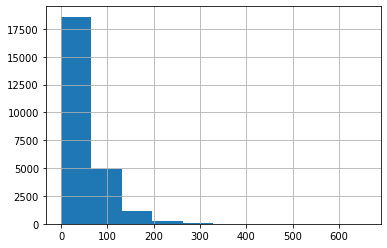

In [ ]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
test['punctuations'] = test['reviews'].apply(lambda x : count(x,set(string.punctuation))   )
test['punctuations'].hist()

In [ ]:
split1_length_0_50 = test[test['punctuations'] <= 50]
split2_length_50_max = test[test['punctuations'] > 50]

In [ ]:
# get_performance(split1_length_0_50)

# predictions for reviews with length less than 2000
# Max document length: 1480
# Vocabulary size: 117362
# Model's performance on 1000 samples of Test Set :  
# Accuracy :  0.834141362592498
# Precision :  0.8779599271402551
# Recall :  0.8023781212841855
# F1 :  0.8384691848906561

In [ ]:
# get_performance(split2_length_50_max)

# predictions for reviews with length less than 2000
# Max document length: 1480
# Vocabulary size: 117362
# Model's performance on 1000 samples of Test Set :  
# Accuracy :  0.7935435435435435
# Precision :  0.8834648940589946
# Recall :  0.7571657468399502
# F1 :  0.8154539353849104

In [ ]:
#print( "Percentage Difference in Accuracy : ", (0.834141362592498 - 0.7935435435435435)*100)
#Percentage Difference in Accuracy :  4.059781904895454

**Entities**

#### a. (5 points) Describe your reason for choosing these two slices. Explain why the model might perform differently on them.

**Answer:**

For this section, I evaluated the difference in the model's performance 
based on accuracy scores for the following splits:

**1) Length of Review**
> a) Split 1 with all reviews having length <= 2000

> b) Split 2 with all reviews having length > 2000


**2) Number of Punctuations**
> a) Split 1 with all reviews having <= 50 punctuation marks

> b) split 2 with all reviews having > 50 punctuation marks


3) Number of Entities (using spacy Named Entity Recognition)
> a) Split 1 with all reviews having total entities <= 15

> b) Split 2 with all reviews having total entities > 15


**Results**

> From the above three categories we chose ***Length of Review*** and ***Number of Entities*** to evalute the performance of our model. That is because, within these slice categories, we could create two subsets of data on which the predictions generated, had on average 5% drop in performance (accuracy) when performance of one slice was compared with the other one.

**Difference in Performance**

> Length of Review : The custom model uses 3 parallel Convolutional layers which extact features from the dataset. These features are then passed through  maxpooling and other fully connected layers with dropout. On this note, in my opinion, as the length of review increases, the CNN model could suffer from the vanishing gradient problem and hence the overall model's performance could degrade with increase in length of the input sequences. The same can be observed from the two category of inputs(short vs long sequences) tested on the model where we notice a 5.77% drop in classification accuracy of the model when working on long sequences, which may be less for this toy dataset, but could result in significant performance issues for larger datasets.

References : https://dl.acm.org/doi/10.1145/1882471.1882478


> Number of Entities : After  looking at the 'length of review' feature distribution for the two slices of data based on 'number of entities' type, we can observe that the slice with more than 15 entities in general are the ones which had longer length reviews in them. This again results in the vanishing gradient problem which was impacting the previous slice type. The distribution is shown below in 2.5 b.







#### b. (2 points) Write code to extract these two slices from your test split.


In [ ]:
################## YOUR CODE HERE ##################

####################################################

**Slice 1  : Length of Review**

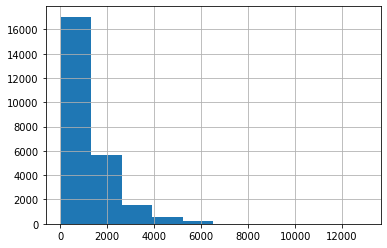

In [ ]:
test['input_length'] = test['reviews'].apply(lambda x : len(x))
test['input_length'].hist()

In [ ]:
split1_length_0_2000 = test[test['input_length'] <= 2000]
split2_length_2000_max = test[test['input_length'] > 2000]

**Slice 2 : Number of Entities**

In [ ]:
import spacy
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [ ]:
def get_entities(text):
  doc = nlp(text)
  count = 0
  for ent in doc.ents:
      count = count + 1
  return count

In [ ]:
test['entities'] = test['reviews'].apply(lambda x : get_entities(x))

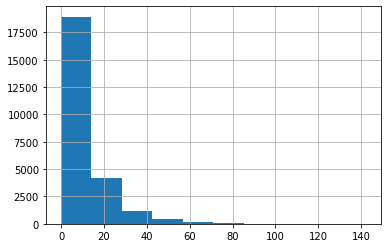

In [ ]:
test['entities'].hist()

In [ ]:
split1_length_0_15 = test[test['entities'] <= 15]
split2_length_15_max = test[test['entities'] > 15]

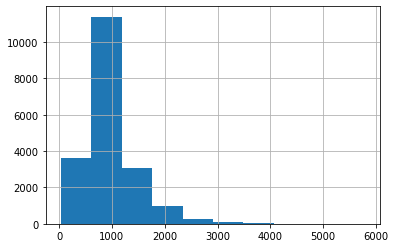

In [ ]:
split1_length_0_15['input_length'].hist()

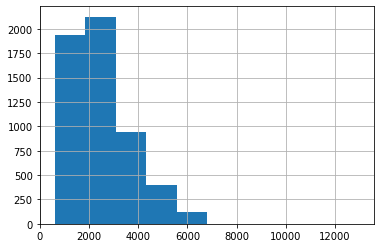

In [ ]:
split2_length_15_max['input_length'].hist()

#### c. (1 point) Write code to report each slice’s statistics. Report the statistics. 
1. Slice size
2. Label distribution

In [ ]:
################## YOUR CODE HERE ##################

####################################################

**Slice 1 - Length of Review**

**Size of Slices**

In [ ]:
print("The size of the slices are as follows : \n")
print( "Total rows in split1_length_0_2000 ",split1_length_0_2000.shape[0])
print( "Total rows in split2_length_2000_max ",split2_length_2000_max.shape[0])

print("The percentage of split1_length_0_2000 as a percentage of all test data : ", (split1_length_0_2000.shape[0]/test.shape[0])*100)
print("The percentage of split2_length_2000_max as a percentage of all test data : ", (split2_length_2000_max.shape[0]/test.shape[0])*100)

The size of the slices are as follows : 

Total rows in split1_length_0_2000  20909
Total rows in split2_length_2000_max  4091
The percentage of split1_length_0_2000 as a percentage of all test data :  83.636
The percentage of split2_length_2000_max as a percentage of all test data :  16.364


**Label Distribution**

In [ ]:
print("Label Distribution : \n")

print("Label Distribution of split1_length_0_2000:\n", split1_length_0_2000['labels'].value_counts())
print("Label Distribution of split2_length_2000_max:\n", split2_length_2000_max['labels'].value_counts())

Label Distribution : 

Label Distribution of split1_length_0_2000:
 0    10507
1    10402
Name: labels, dtype: int64
Label Distribution of split2_length_2000_max:
 1    2098
0    1993
Name: labels, dtype: int64


**Slice 2 - Number of Entities**

**Size of Slices**

In [ ]:

print("The size of the slices are as follows : \n")
print( "Total rows in split1_length_0_15 ",split1_length_0_15.shape[0])
print( "Total rows in split2_length_15_max ",split2_length_15_max.shape[0])

print("The percentage of split1_length_0_15 as a percentage of all test data : ", (split1_length_0_15.shape[0]/test.shape[0])*100)
print("The percentage of split2_length_15_max as a percentage of all test data : ", (split2_length_15_max.shape[0]/test.shape[0])*100)

The size of the slices are as follows : 

Total rows in split1_length_0_15  19470
Total rows in split2_length_15_max  5530
The percentage of split1_length_0_15 as a percentage of all test data :  77.88000000000001
The percentage of split2_length_15_max as a percentage of all test data :  22.12


**Label Distribution**

In [ ]:
print("Label Distribution : \n")

print("Label Distribution of split1_length_0_15:\n", split1_length_0_15['labels'].value_counts())
print("Label Distribution of split2_length_15_max:\n", split2_length_15_max['labels'].value_counts())

Label Distribution : 

Label Distribution of split1_length_0_15:
 0    10162
1     9308
Name: labels, dtype: int64
Label Distribution of split2_length_15_max:
 1    3192
0    2338
Name: labels, dtype: int64


#### d. (1 point) Write code to evaluate **your model** performance on these two slices, including the metric specified in 1.2 (c) and the confusion matrix.
- [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) may be useful here


**Performance Evaluation : Length of Review Slices**

In [ ]:
def get_performance(data):
  print("predictions for reviews with length less than 2000")
  sample_encoding, labels = transform_sample_data(data)
  predictions_sample = model.predict([sample_encoding,sample_encoding,sample_encoding], batch_size = 16)
  predictions_sample = list(predictions_sample)
  predictions_sample = pd.DataFrame(predictions_sample, columns = ['Probabilities'])
  selected_threshold = 0.733
  predictions_sample['Labels'] = predictions_sample['Probabilities'].apply(lambda x :  1 if x >= selected_threshold else  0)
  get_model_performance(labels, list(predictions_sample['Labels']))

In [ ]:
get_performance(split1_length_0_2000)

predictions for reviews with length less than 2000
Max document length: 1480
Vocabulary size: 117362
Model's performance on 1000 samples of Test Set :  
Accuracy :  0.8284470802046966
Precision :  0.8773198819834396
Recall :  0.8004515456755817
F1 :  0.8371248240475865


In [ ]:
get_performance(split2_length_2000_max)

predictions for reviews with length less than 2000
Max document length: 1480
Vocabulary size: 117362
Model's performance on 1000 samples of Test Set :  
Accuracy :  0.7707162063065265
Precision :  0.8946312092323131
Recall :  0.7100756670649144
F1 :  0.7917406749555952


In [ ]:
print( "Percentage Difference in Accuracy : ", (0.8284470802046966 - 0.7707162063065265) * 100)

Percentage Difference in Accuracy :  5.773087389817011


**Performance Evaluation : Number of Entities**

In [ ]:
get_performance(split1_length_0_15)

predictions for reviews with length less than 2000
Max document length: 1480
Vocabulary size: 117362
Model's performance on 1000 samples of Test Set :  
Accuracy :  0.8330251669234721
Precision :  0.8873253296595158
Recall :  0.8106625910276005
F1 :  0.8472633309842613


In [ ]:
get_performance(split2_length_15_max)

predictions for reviews with length less than 2000
Max document length: 1480
Vocabulary size: 117362
Model's performance on 1000 samples of Test Set :  
Accuracy :  0.769620253164557
Precision :  0.8485885372112917
Recall :  0.6831955922865014
F1 :  0.7569629912247234


In [ ]:
print( "Percentage Difference in Accuracy : ", (0.8330251669234721 - 0.769620253164557)*100)

Percentage Difference in Accuracy :  6.34049137589151


#### e. (1 point) Write code to evaluate the **fine-tuned model** performance on these two slices, including the metric specified in 1.2 (c) and the confusion matrix.

In [ ]:
################## YOUR CODE HERE ##################

####################################################

**Model Performance - Length of Review**

In [ ]:
def get_performance_on_slice(data):
  sample_testData_encodings = tokenizer(data['reviews'].to_list(), truncation=True, padding = "max_length")
  sample_testDataset = my_Dataset(sample_testData_encodings, data['labels'].to_list())
  predictions_sample=trainer.predict(sample_testDataset)
  y_pred = list(predictions_sample.label_ids)
  predictions_tensor = torch.from_numpy(predictions_sample.predictions)
  #predictions_tensor = torch.from_numpy(predictions_sample.predictions)
  predictions = torch.nn.functional.softmax(predictions_tensor, dim=-1)
  predictions = predictions.cpu().detach().numpy()
  resulting_probabilities = pd.DataFrame(predictions)
  class1_probabilities = list(predictions[:,1])
  class1_labels = [1 if item > 0.5 else 0 for item in class1_probabilities]
  result_sample_test = pd.DataFrame(list(zip(class1_probabilities,class1_labels)), columns = ['Probabilities','Labels'])
  get_model_performance(data['labels'], list(result_sample_test['Labels']))
  return 

In [ ]:
get_performance_on_slice(split1_length_0_2000)

***** Running Prediction *****
  Num examples = 20909
  Batch size = 4


Model's performance on 1000 samples of Test Set :  
Accuracy :  0.9288822994882586
Precision :  0.9365185114685448
Recall :  0.9230769230769231
F1 :  0.9297491378088534


In [ ]:
get_performance_on_slice(split2_length_2000_max)

***** Running Prediction *****
  Num examples = 4091
  Batch size = 4


Model's performance on 1000 samples of Test Set :  
Accuracy :  0.8880469322903936
Precision :  0.9006522829904666
Recall :  0.8734793187347932
F1 :  0.8868577075098815


***Performance Evaluation : **Number** of Entities***

In [ ]:
get_performance_on_slice(split1_length_0_15)

***** Running Prediction *****
  Num examples = 19470
  Batch size = 4


Model's performance on 1000 samples of Test Set :  
Accuracy :  0.9312275295326142
Precision :  0.942432592009447
Recall :  0.9270157777562675
F1 :  0.934660615820036


In [ ]:
get_performance_on_slice(split2_length_15_max)

***** Running Prediction *****
  Num examples = 5530
  Batch size = 4


Model's performance on 1000 samples of Test Set :  
Accuracy :  0.8904159132007233
Precision :  0.8802395209580839
Recall :  0.863255033557047
F1 :  0.8716645489199494


## Problem 3. In-Distribution v.s. Out-of-Distribution

In problem 2, when we evaluate the fine-tuned model on the test split that comes from the same distribution the model was fine-tuned on. In this problem, we’ll evaluate the fine-tuned model’s performance on an out-of-distribution test set.


### 3.1 Evaluate the fine-tuned model on an out-of-distribution task [4 points]


#### a. (1 point) If the dataset has a test split, randomly sample 500 examples from the test split. If it doesn’t have a test split, randomly sample 500 samples from the entire dataset.


In [ ]:
################## YOUR CODE HERE ##################

####################################################

from datasets import list_datasets
from datasets import load_dataset
import pandas as pd
datasets_list = list_datasets()
len(datasets_list)
print(', '.join(dataset for dataset in datasets_list))


acronym_identification, ade_corpus_v2, adversarial_qa, aeslc, afrikaans_ner_corpus, ag_news, ai2_arc, air_dialogue, ajgt_twitter_ar, allegro_reviews, allocine, alt, amazon_polarity, amazon_reviews_multi, amazon_us_reviews, ambig_qa, americas_nli, ami, amttl, anli, app_reviews, aqua_rat, aquamuse, ar_cov19, ar_res_reviews, ar_sarcasm, arabic_billion_words, arabic_pos_dialect, arabic_speech_corpus, arcd, arsentd_lev, art, arxiv_dataset, ascent_kb, aslg_pc12, asnq, asset, assin, assin2, atomic, autshumato, babi_qa, banking77, bbaw_egyptian, bbc_hindi_nli, bc2gm_corpus, beans, best2009, bianet, bible_para, big_patent, billsum, bing_coronavirus_query_set, biomrc, biosses, blbooks, blbooksgenre, blended_skill_talk, blimp, blog_authorship_corpus, bn_hate_speech, bnl_newspapers, bookcorpus, bookcorpusopen, boolq, bprec, break_data, brwac, bsd_ja_en, bswac, c3, c4, cail2018, caner, capes, casino, catalonia_independence, cats_vs_dogs, cawac, cbt, cc100, cc_news, ccaligned_multilingual, cdsc, cdt

In [ ]:
dataset = load_dataset('amazon_us_reviews', 'Mobile_Electronics_v1_00')
dataset = pd.DataFrame(dataset['train'][:])
dataset["Sentiment"] = dataset["star_rating"].apply(lambda score: "positive" if score >= 3 else "negative")
dataset['Sentiment'] = dataset['Sentiment'].map({'positive':1, 'negative':0})
dataset = dataset[['review_body','Sentiment']]
dataset.columns = ['reviews','labels']

Reusing dataset amazon_us_reviews (/root/.cache/huggingface/datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
sample_percentage = 500/dataset.shape[0]

out_sample_500 = dataset.sample(frac= sample_percentage, replace=True, random_state=412)

In [ ]:
out_sample_500

,reviews,labels
90098,This mount survived a motorcycle crash that th...,1
12172,Got these to use on desktop and laptop compute...,1
74597,I love this little guy. I actually own two of ...,1
29930,I bought this amp in need of something for my ...,1
90385,"I love this ebook reader, I can change the fon...",1
...,...,...
65945,Best $20.00 I've ever spent. Nice sound with ...,1
18593,The device works. The software fails to contro...,0
10565,Yeah bad idea to run these @ 1ohm on 3000 watt...,1
104162,"This charger is great, it plugs directly into ...",1


#### b. (1 point) Use the fine-tuned model to make predictions on these examples and output predicted labels and associated probabilities.


In [ ]:
################## YOUR CODE HERE ##################

####################################################

In [ ]:
def make_predictions_out_sample(data):
  sample_testData_encodings = tokenizer(data['reviews'].to_list(), truncation=True, padding = "max_length")
  sample_testDataset = my_Dataset(sample_testData_encodings, data['labels'].to_list())
  predictions_sample=trainer.predict(sample_testDataset)
  y_pred = list(predictions_sample.label_ids)
  predictions_tensor = torch.from_numpy(predictions_sample.predictions)
  #predictions_tensor = torch.from_numpy(predictions_sample.predictions)
  predictions = torch.nn.functional.softmax(predictions_tensor, dim=-1)
  predictions = predictions.cpu().detach().numpy()
  resulting_probabilities = pd.DataFrame(predictions)
  class1_probabilities = list(predictions[:,1])
  class1_labels = [1 if item > 0.5 else 0 for item in class1_probabilities]
  result_sample_test = pd.DataFrame(list(zip(class1_probabilities,class1_labels)), columns = ['Probabilities','Labels'])
  return result_sample_test

In [ ]:
out_sample_500 = out_sample_500.reset_index().iloc[:,1:]

result_out_sample_test = make_predictions_out_sample(out_sample_500)

***** Running Prediction *****
  Num examples = 500
  Batch size = 4


In [ ]:
result_out_sample_test

,Probabilities,Labels
0,0.903601,1
1,0.999856,1
2,0.999986,1
3,0.003295,0
4,0.999985,1
...,...,...
495,0.998073,1
496,0.000010,0
497,0.000013,0
498,0.999828,1


#### c. (1 point) Evaluate the fine-tuned model’s performance on these 500 examples using the metric specified in 1.2 (c).


In [ ]:
################## YOUR CODE HERE ##################

####################################################

In [ ]:
get_model_performance(list(out_sample_500['labels']), list(result_out_sample_test['Labels']))

Model's performance on  500  samples of Test Set :  
Accuracy :  0.816
Precision :  0.936
Recall :  0.582089552238806
F1 :  0.7177914110429447


#### d. (1 point) Compare the performance of the fine-tuned model on IMDB and this dataset.


Answer


Assumption : I am assuming that by IMDB dataset, the instructors are referring to the sample of the test set we created in 2.1 e.

Model's performance on 1000 samples of Test Set :  
  

> Accuracy :  0.939

> Precision :  0.9468302658486708

> Recall :  0.929718875502008

> F1 :  0.9381965552178317




Model's performance on  500  samples of Test Set :  

> Accuracy :  0.816

> Precision :  0.936

> Recall :  0.582089552238806

> F1 :  0.7177914110429447






### 3.2 Error analysis of the fine-tuned model on out-of-distribution task [10 points]

Next, do error analysis on the examples that the fine-tuned model failed to predict correctly. This is a common debugging step where buckets of errors are identified to inform how the model might be improved.


#### a. (1 point) Pull out the examples that your fine-tuned model made errors on.


In [ ]:
################## YOUR CODE HERE ##################

####################################################

In [ ]:
all_predictions_gt = pd.concat([out_sample_500, result_out_sample_test], axis = 1)
mismatches  = all_predictions_gt[all_predictions_gt['labels'] !=  all_predictions_gt['Labels']]

In [ ]:
matches = all_predictions_gt[all_predictions_gt['labels'] ==  all_predictions_gt['Labels']]

In [ ]:
mismatches

,reviews,labels,Probabilities,Labels
3,I bought this amp in need of something for my ...,1,0.003295,0
12,"Well,<br />I broke mine in under 48hrs, but it...",1,0.000033,0
16,This will protect your screen and help prevent...,1,0.000475,0
19,"Portability, sound quality, battery life all w...",1,0.000184,0
22,I love the look of this case...It fits just fi...,1,0.001033,0
...,...,...,...,...
460,I bought this so I could listen to my podcasts...,1,0.000387,0
469,For some reason I did not think fingerprints w...,0,0.992239,1
489,Bought the product for a 10&#34; kicker cvr. O...,0,0.998635,1
490,My RDS traffic service quit working on my GPS....,1,0.000029,0


#### b. (3 points) Identify at least 1 pattern that you believe your model is missing. Include at least 3 examples from the data that support your hypothesis.


**Answer:**

In my opinion,a noticeable pattern in the reivews were incorrectly classified is the unclear distinction between which side the user is taking when talking about the product in question. For reviews where the user talks both in favor and against the product are missclassified by the model.

**The below cells showcase reviews which had mismatches**


***Mismatches***

In [ ]:
mismatches.iloc[2,0]

"This will protect your screen and help prevent fingerprints from accumulating all over.  It is a matte screen protector.  That means it WILL degrade the sharpness of the screen somewhat.  If you don't want fingerprints, this is for you.  If you don't mind the fingerprints and want a protector that will preserve the clarity of the screen, get a clear protector.  You can't have it both ways.<br /><br />Also, the matte finish will make the S-pen feel sluggish while using it on the protector.  Some say that it helps them write better.  Others say you can change the S-pen tip to get a more smooth feel from it.  I haven't tried replacing the tip because the different feel of the pen doesn't bother me."

In [ ]:
mismatches.iloc[1,0]

"Well,<br />I broke mine in under 48hrs, but it was my own doing.<br /><br />- Seller delivered as promised, so you can trust these folks.<br />- Speaker isn't very good, but using your favorite headphones will be fine.<br />- microSD card support is true.<br />- It's pretty much in english.<br /><br />Warning#1 - Don't buy this if you're overweight; your fingers won't be able use the touch-screen well because the icons are small. I have no problem with it, but I'm not overweight... anymore.<br />Warning#2 - Don't be surprised if this doesn't play your MP4s well, or at all. Example, Diggnation podcasts.<br />Warning#3 - Don't upgrade the firmware, I did... and bricked it. I almost recovered it, but it went super-brick on me(not even seen by the PC/Linux at all) so now it's really broke. And that was in less than 48hrs of owning it!<br /><br />Would I order from these guys again? Sure, as soon as I figure out what other Korean PMP thing I want."

In [ ]:
mismatches.iloc[5,0]

'Despite what others have said, this being a difficult project, it is not as bad as it seems.  Took about a full day to do, but once it was done it worked like a charm.  Good range, starts immediately.  I have a 2002 GMC Sonoma with Passlock II that I had to bypass.  I used a PLJX (I believe it was) and grounded the wire that was supposed to go to the remote start (this completely disabled the anti-theft, as I didn\'t want it active anyway) and used a wiring diagram from    [...]    The instructions were a little vague, but essentially all you need is the ignition, start, accessory,12v power, ground, and I would recommend the brake safety.  I opted not to install the hood mount safety and some of the other ones.  You do not need to hook your tach up to this unit, it has a \\\\"self-learn\\\\" feature that works rather well.  If you are not comfortable wiring or taking apart your vehicle or you are just incompetent in general, do not try this.  However, Best Buy quoted me $400 in labor,

#### c. (2 points) Explain why these examples might have been difficult for the fine-tuned model to correctly make predictions on.


**Answer:**


I believe a reason for misclassification is that though reviewers are speaking in favor of the product they bought, yet the comparison they are making with other product, or discussion of shortcomings of the product in question is taken by the model in a negative light. For example:

In the first example listed, the reviewer is in favor of the product and also makes the following comment : "If you don't want fingerprints, this is for you.  If you don't mind the fingerprints and want a protector that will preserve the clarity of the screen, get a clear protector."

Next, in the second example, the reviewer is in favor of buying the product by saying the following "Would I order from these guys again? Sure, as soon as I figure out what other Korean PMP thing I want", but also says "Don't buy this if you're overweight; your fingers won't be able use the touch-screen well because the icons are small." which is against the product in question.

Lastly, in the third review, the reviewer is seemingly in favor of using the product but then also says the following "If you are not comfortable wiring or taking apart your vehicle or you are just incompetent in general, do not try this" which has a negative connotation to it and is thus misclassified.

We could also explore the usage of punctuation marks in both matches and mismatches datasets, and look at the distribution of punctuations in the reviews present in these datasets

In [ ]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
matches['punctuations'] = matches['reviews'].apply(lambda x : count(x,set(string.punctuation)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


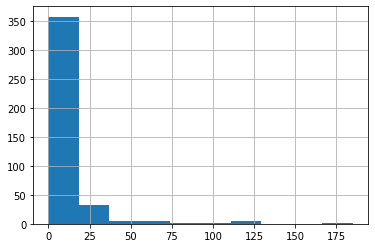

In [ ]:
matches['punctuations'].hist()

In [ ]:
mismatches['punctuations'] = mismatches['reviews'].apply(lambda x : count(x,set(string.punctuation)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


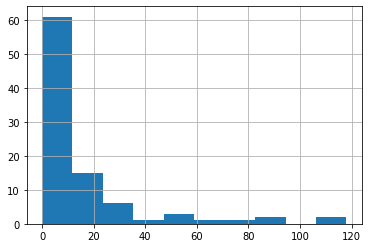

In [ ]:
mismatches['punctuations'].hist()

From the above histogram plots, we can observe that the reviews which were correctly classified (matches) actually had more punctuation marks, than the reviews having incorrect predicted labels. Therefore punctuation marks cannot be a reason for the low performance of the tuned-model on this out of sample dataset

#### d. (2 points) Manually write down 3 examples that conform to the pattern you observed, and run inference on them using the model. What did you find?


In [ ]:
example1 = "I loved the look! The knob to turn it on and off felt cheap hard to turn on and not pass FM always went to am and gently back to fm. Very cheap plastic but still super cute. I am sad it only lasted about 45 days and died if your handy you could probably take apart and solder some wires I did not attempt that just returned they kept about 5 bucks for my return. I’d love another just for the looks but don’t need if it’s gonna die quickly."
label1 = 0
example2 = "It's true to the image, works well enough, easy tune, simple dials a monkey can figure out lol.... I like it. It is not bluetooth enabled however, it states this but I figured I would again because I ran into a teeny issue..... I saw it has the standard audio jack adaptor option... yes, more cords so annoying. But it's down in my greenhouse for my plants so it is fine. However, it won't play anything through it's headphone jack adaptor. No matter which tablet, iPhone, ipod device I've tried....even my mac book lol. So it was devices, so I tried switching the cords to see if it was pucky there. Nope. Nothing. My sound will be up on my device's media, it knows it isn't playing from it's speakers....but nothing comes from the stereo speakers.... The only reasonable thing I can imagine is maybe yhe a tual place you connect t to the Jack is jisy not having it lol Everything else works as expected. The usual dial that you turn from off to FM to AM with one dial. Then the other dial controls the volume. The tuner is located on the front area. It gives it the old look for sure. Sound is good not a lot of static except way up by edmonton in the boonies. But hey, who's surprised there?!" 
label2 = 1
example3 = "Loved this radio for a few weeks, used it outside while gardening, worked great for a few weeks, then nothing but static. Changed batteries, etc. I don't think it's a quality product, but it is cute."
label3 = 0

In [ ]:
examples = [example1, example2, example3]
labels = [label1, label2, label3]
sample_ooo = pd.DataFrame(list(zip(examples, labels)), columns = ['reviews','labels'])

In [ ]:
sample_ooo

,reviews,labels
0,I loved the look! The knob to turn it on and o...,0
1,"It's true to the image, works well enough, eas...",1
2,"Loved this radio for a few weeks, used it outs...",0


In [ ]:
result_out_sample_test = make_predictions_out_sample(sample_ooo)

***** Running Prediction *****
  Num examples = 3
  Batch size = 4


In [ ]:
result_out_sample_test

,Probabilities,Labels
0,0.997322,1
1,0.000548,0
2,0.999964,1


In [ ]:
result = pd.concat([sample_ooo, result_out_sample_test], axis = 1)
result

,reviews,labels,Probabilities,Labels
0,I loved the look! The knob to turn it on and o...,0,0.997322,1
1,"It's true to the image, works well enough, eas...",1,0.000548,0
2,"Loved this radio for a few weeks, used it outs...",0,0.999964,1


In [ ]:
################## YOUR CODE HERE ##################
# Inference on your own examples
####################################################

**Answer:**

The above examples just like the mismatches talk about the product in both negativ and positive light, and as hypothesized earlier are incorrectly classified by the model 

#### e. (2 points) Suggest what steps we might take to address this error bucket.


**Answer:**

[YOUR ANSWER HERE]

### 3.3 Calibration [4 points]
You will examine whether the fine-tuned model is calibrated. You might want to look into [sklearn.calibration.calibration_curve](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html).


#### a. (1 point) Compute the average calibration error of the fine-tuned model on IMDB.


In [ ]:
################## YOUR CODE HERE ##################

####################################################

#### b. (1 point) Compute the average calibration error of the fine-tuned model on the out-of-distribution dataset


In [ ]:
################## YOUR CODE HERE ##################

####################################################

#### c. (2 points) Plot the calibration curves for the fine-tuned model on both datasets.


In [ ]:
################## YOUR CODE HERE ##################

####################################################

**Answer:**

[YOUR ANSWER HERE]

## Problem 4. Multilabel Tasks [20 points]

Now we’ll be using our understanding of pretrained models and fine-tuned models to try to get good performance on a difficult dataset.

Choose one of the following multilabel tasks:
- Circa dataset: https://huggingface.co/datasets/circa 
- PUBHEALTH dataset: https://huggingface.co/datasets/health_fact
- GoEmotions dataset: https://huggingface.co/datasets/go_emotions

**Tip:** read the paper associated with each dataset.


### 4.1 Analyze a multi-label classification dataset [7 points]

#### a. (2 points) Describe the train/test split distributions, the dataset’s columns, and their statistics.


**Answer:**

[YOUR ANSWER HERE]

#### b. (1 point) Plot its label distribution as a bar graph, with the labels on the x-axis and number of examples for each labels on the y-axis.


In [ ]:
################## YOUR CODE HERE ##################
# See https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.bar.html
####################################################

**Answer:**

[YOUR ANSWER HERE]

#### c. (2 points) What metric(s) would be appropriate for this dataset? Why?


**Answer:**

[YOUR ANSWER HERE]

#### d. (2 points) Explain why you might think that this dataset is hard.


**Answer:**

[YOUR ANSWER HERE]

### 4.2 Fine-tuning a model for your multi-label classification task [13 points]

#### a. (1 point) Select a pre-trained model and instantiate it with the appropriate number of classes for your task. You are free to choose any framework you'd like for this part (HuggingFace's models, PyTorch, TensorFlow, etc.) 

In [ ]:
################## YOUR CODE HERE ##################

####################################################

#### b. (3 points) Pre-process the dataset for training and evaluation 

In [ ]:
################## YOUR CODE HERE ##################

####################################################

#### c. (3 points) Fine tune the model on the pre-processed dataset

In [ ]:
################## YOUR CODE HERE ##################

####################################################

#### d. (3 points) Evaluate your model using the metrics you identified in 4.1 (c). 

In [ ]:
################## YOUR CODE HERE ##################

####################################################

#### e. (3 points) On what class of labels does your fine-tuned model perform particularly well? On what class of labels does your model not do well? Where might you find or how might you construct new examples of this class to supplement your model's training? 

For those who chose to analyze the GoEmotions dataset, a list of the emotions used in the dataset can be found [here](https://github.com/google-research/google-research/blob/master/goemotions/data/emotions.txt)

**Answer:**

[YOUR ANSWER HERE]